In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
BUFFER_SIZE = 70_000
BATCH_SIZE = 128
NUM_EPOCHS = 20


In [3]:
mnist_dataset,mnist_info = tfds.load(name ='mnist' , with_info =True , as_supervised = True )

In [4]:
mnist_train ,mnist_test = mnist_dataset['train'] , mnist_dataset['test']

mnist_info

In [5]:
mnist_info

tfds.core.DatasetInfo(
    name='mnist',
    version=1.0.0,
    description='The MNIST database of handwritten digits.',
    urls=['https://storage.googleapis.com/cvdf-datasets/mnist/'],
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

In [6]:
def scale(image , label):
    image = tf.cast(image , tf.float32)
    image/=256.
    return image , label

In [7]:
train_and_validation = mnist_train.map(scale)
test = mnist_test.map(scale)

In [8]:
num_validation_samples = 0.1 * mnist_info.splits['train'].num_examples
num_validation_samples = tf.cast(num_validation_samples , tf.int64)

In [9]:
num_test_samples = 0.1 * mnist_info.splits['test'].num_examples
num_test_samples = tf.cast(num_test_samples , tf.int64)

In [10]:
train_and_validation =train_and_validation.shuffle(BUFFER_SIZE)

In [11]:
train_data =train_and_validation.skip(num_validation_samples)
validation_data =train_and_validation.take(num_validation_samples)

In [12]:
train_data =train_data.batch(BATCH_SIZE)
validation_data =validation_data.batch(BATCH_SIZE)
test_data = test.batch(BATCH_SIZE)

## create the model and training it

In [13]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [16]:
# Outlining the model/architecture of our CNN
# CONV -> MAXPOOL -> CONV -> MAXPOOL -> FLATTEN -> DENSE
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(50, 5, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
    # (2,2) is the default pool size so we could have just used MaxPooling2D() with no explicit arguments
    tf.keras.layers.Conv2D(50, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10) # You can apply softmax activation here, see below for comentary
])

In [17]:
model.summary(line_length =75)

Model: "sequential"
___________________________________________________________________________
Layer (type)                     Output Shape                  Param #     
conv2d (Conv2D)                  (None, 24, 24, 50)            1300        
___________________________________________________________________________
max_pooling2d (MaxPooling2D)     (None, 12, 12, 50)            0           
___________________________________________________________________________
conv2d_1 (Conv2D)                (None, 10, 10, 50)            22550       
___________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 5, 5, 50)              0           
___________________________________________________________________________
flatten (Flatten)                (None, 1250)                  0           
___________________________________________________________________________
dense (Dense)                    (None, 10)                    12510

In [18]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [19]:
model.compile(optimizer='adam' , loss=loss_fn , metrics = ['accuracy'])

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor= 'val_loss',
    mode  = 'auto',
    min_delta = 0 ,
    patience = 2 ,
    verbose = 0 ,
    restore_best_weights = True,

)

In [21]:
model.fit(
train_data , epochs = NUM_EPOCHS , callbacks = [early_stopping]  ,
validation_data = validation_data
    ,verbose =2
)

Epoch 1/20
422/422 - 31s - loss: 0.2744 - accuracy: 0.9216 - val_loss: 0.0868 - val_accuracy: 0.9760
Epoch 2/20
422/422 - 30s - loss: 0.0718 - accuracy: 0.9787 - val_loss: 0.0574 - val_accuracy: 0.9818
Epoch 3/20
422/422 - 29s - loss: 0.0526 - accuracy: 0.9839 - val_loss: 0.0433 - val_accuracy: 0.9885
Epoch 4/20
422/422 - 28s - loss: 0.0437 - accuracy: 0.9866 - val_loss: 0.0425 - val_accuracy: 0.9870
Epoch 5/20
422/422 - 27s - loss: 0.0381 - accuracy: 0.9881 - val_loss: 0.0315 - val_accuracy: 0.9888
Epoch 6/20
422/422 - 33s - loss: 0.0317 - accuracy: 0.9905 - val_loss: 0.0225 - val_accuracy: 0.9932
Epoch 7/20
422/422 - 34s - loss: 0.0297 - accuracy: 0.9906 - val_loss: 0.0187 - val_accuracy: 0.9943
Epoch 8/20
422/422 - 35s - loss: 0.0253 - accuracy: 0.9917 - val_loss: 0.0323 - val_accuracy: 0.9917
Epoch 9/20
422/422 - 36s - loss: 0.0235 - accuracy: 0.9926 - val_loss: 0.0156 - val_accuracy: 0.9955
Epoch 10/20
422/422 - 33s - loss: 0.0194 - accuracy: 0.9941 - val_loss: 0.0126 - val_accura

## Testing our model

In [22]:
#use evaluate method
test_loss , test_accuracy = model.evaluate(test_data)

79/79 [==============================] - 2s 24ms/step - loss: 0.0367 - accuracy: 0.9901


In [23]:
print(f"test loss : {test_loss:.4f} , test_accuracy : {test_accuracy*100 :.4f}")

test loss : 0.0367 , test_accuracy : 99.0100


# plotting images and results

In [24]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
# Split the test_data into 2 arrays, containing the images and the corresponding labels
for images, labels in test_data.take(1):
    images_test = images.numpy()
    labels_test = labels.numpy()

# Reshape the images into 28x28 form, suitable for matplotlib (original dimensions: 28x28x1)
images_plot = np.reshape(images_test, (128,28,28))

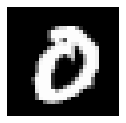

In [27]:
#the image to be displayed and tested
i = 55

plt.figure(figsize=(2,2))
plt.axis('off')
plt.imshow(images_plot[i-1] ,cmap = "gray" , aspect = 'auto')


<BarContainer object of 10 artists>

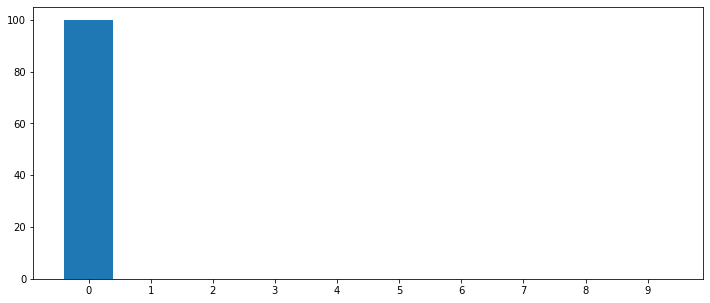

In [28]:
# Obtain the model's predictions (logits)
predictions = model.predict(images_test[i-1:i])

# Convert those predictions into probabilities (recall that we incorporated the softmaxt activation into the loss function)
probabilities = tf.nn.softmax(predictions).numpy()
# Convert the probabilities into percentages
probabilities = probabilities*100


# Create a bar chart to plot the probabilities for each class
plt.figure(figsize=(12,5))
plt.bar(x=[1,2,3,4,5,6,7,8,9,10], height=probabilities[0], tick_label=["0","1","2","3","4","5","6","7","8","9"])